This script generates a Binary Decision Diagram (BDD) for a formal model of an approximate full adder with variable bit width.


10.2021, Fabian Garber, Simon Howind, Kagan Özten, Martin Resetarits, Peter Traunmüller 

Contact: e1326142@student.tuwien.ac.at

In [283]:
#Import necessary libraries
from pyeda.inter import * # <--this is from the official wiki, don't judge

#GVmagic is a package to use the external GraphViz library inside python
%load_ext gvmagic

The gvmagic extension is already loaded. To reload it, use:
  %reload_ext gvmagic


In [284]:
#Variables
input_width = 4

VHDL from Kagan

 -- Full adder (exact)
 
S <= A XOR B XOR Cin ;

Cout <= (A AND B) OR (Cin AND A) OR (Cin AND B) ;

-- Full adder INXA1 (Approx.)

s_inv_1 <= A XOR B XOR Cin ; -- Signal for binding S_a and Cout_a

S_a <= s_inv_1;

Cout_a <= NOT(s_inv_1) ;

In [285]:
#Approximate full adder type INXA1:
def approx_full_adder_bit(a_in, b_in, carry_in):
    #cast to bool in case we've thrown in ints
    a_in = bool(int(a_in))
    b_in = bool(int(b_in))
    carry_in = bool(int(carry_in))
    
    s_out = (a_in ^ b_in ) ^ carry_in
    c_out = not s_out
    
    return s_out,c_out

#n-bit approx. full adder
def approx_full_adder(a_in, b_in, input_width):
    bin_format = "{0:0"+str(input_width)+"b}" #{0:08b}
    
    #format the input as string so we can pick single values
    a_in_bin_str = str(bin_format.format(a_in)) #"01101001"
    b_in_bin_str = str(bin_format.format(b_in)) #"01110101"
    
    #initialize vars for the loop
    carry_out = 0
    out = [0] * (input_width+1)
    
    #loop through each digit of the bin and use our approx adder
    for i in range(input_width, 0, -1):
        out[i],carry_out = approx_full_adder_bit(a_in_bin_str[i-1], b_in_bin_str[i-1], carry_out)
    
    #add the carry as leading digit
    out[0]=carry_out  
    return out
    
#approx_full_adder(0b1111, 0b0000, 4)
print("approx:"+str(list(map(int, approx_full_adder(0b0000, 0b0000, 4)))))


approx:[0, 1, 0, 1, 0]


In [286]:
from pprint import pprint

#exact full adder:
def exact_full_adder_bit(a_in, b_in, carry_in):
    #cast to bool in case we've thrown in ints
    a_in = bool(int(a_in))
    b_in = bool(int(b_in))
    carry_in = bool(int(carry_in))
    
    s_out = (a_in ^ b_in ) ^ carry_in
    c_out = (a_in & b_in ) | (a_in & carry_in ) | (carry_in & b_in )
    
    return s_out,c_out

#n-bit exact full adder
def exact_full_adder(a_in, b_in, input_width):
    bin_format = "{0:0"+str(input_width)+"b}" #{0:08b}
    
    #format the input as string so we can pick single values
    a_in_bin_str = str(bin_format.format(a_in)) #"01101001"
    b_in_bin_str = str(bin_format.format(b_in)) #"01110101"
        
    #initialize vars for the loop
    carry_out = 0
    out = [0] * (input_width+1)
    
    #loop through each digit of the bin and use our exact adder
    for i in range(input_width, 0, -1):
        out[i],carry_out = exact_full_adder_bit(a_in_bin_str[i-1], b_in_bin_str[i-1], carry_out)
    
    #add the carry as leading digit
    out[0]=carry_out  
    return out
    
#exact_full_adder(0b1111, 0b0000, 4)
print("exact:"+str(list(map(int, exact_full_adder(0b001, 0b100, 3)))))

exact:[0, 1, 0, 1]


In [288]:
#test the adders with numbers

for i in range( 2**input_width):
    for j in range( 2**input_width):
        bin_format = "{0:0"+str(input_width)+"b}" #{0:08b}
        print(""+str(bin_format.format(i)), end =" + ")
        print(""+str(bin_format.format(j)), end =" = ")
        
        approx_result = approx_full_adder(i, j, 4)
        approx_result_int = 0
        for k in range(5):
            approx_result_int =  approx_result_int + int(approx_result[k]) * 2**(4-k)
        bin_format_plus1 = "{0:0"+str(input_width+1)+"b}" #{0:08b}    
        print("approx:" + bin_format_plus1.format(approx_result_int), end =", ")
        
        exact_result = exact_full_adder(i, j, 4)
        exact_result_int = 0
        for k in range(5):
            exact_result_int =  exact_result_int + int(exact_result[k]) * 2**(4-k)
        print("exact:" + bin_format_plus1.format(exact_result_int), end =", ")
        
        print()

0000 + 0000 = approx:01010, exact:00000, 
0000 + 0001 = approx:10101, exact:00001, 
0000 + 0010 = approx:10100, exact:00010, 
0000 + 0011 = approx:01011, exact:00011, 
0000 + 0100 = approx:10110, exact:00100, 
0000 + 0101 = approx:01001, exact:00101, 
0000 + 0110 = approx:01000, exact:00110, 
0000 + 0111 = approx:10111, exact:00111, 
0000 + 1000 = approx:10010, exact:01000, 
0000 + 1001 = approx:01101, exact:01001, 
0000 + 1010 = approx:01100, exact:01010, 
0000 + 1011 = approx:10011, exact:01011, 
0000 + 1100 = approx:01110, exact:01100, 
0000 + 1101 = approx:10001, exact:01101, 
0000 + 1110 = approx:10000, exact:01110, 
0000 + 1111 = approx:01111, exact:01111, 
0001 + 0000 = approx:10101, exact:00001, 
0001 + 0001 = approx:01010, exact:00010, 
0001 + 0010 = approx:01011, exact:00011, 
0001 + 0011 = approx:10100, exact:00100, 
0001 + 0100 = approx:01001, exact:00101, 
0001 + 0101 = approx:10110, exact:00110, 
0001 + 0110 = approx:10111, exact:00111, 
0001 + 0111 = approx:01000, exact:

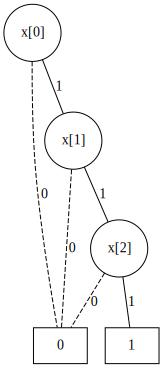

In [158]:
X = exprvars('x', 3)
f = truthtable(X, "00000001")
test_expr = truthtable2expr(f)
test_expr_bdd = expr2bdd(test_expr)
%dotobj test_expr_bdd

TypeError: 'Variable' object is not subscriptable

Stuff to look back at later

In [ ]:
#Generate BDD variables with the rigth width
input_A = bddvars('input_a', input_width)
input_B = bddvars('input_b', input_width)
carry_C = bddvars('carry_c', input_width)


for i in range(input_width):
    if i == 0: #catch the case for the "zeroth" bit
        approx_add_func_S= (input_A[i] ^ input_B[i]) ^ False
        approx_add_func_C = ~((input_A[i] ^ input_B[i]) ^ False)
        exact_add_func_S = (input_A[i] ^ input_B[i]) ^ False
        exact_add_func_C = (input_A[i] & input_B[i]) | (input_A[i] & False) | (False & input_B[i])
        
    else:
        approx_add_func_S= (input_A[i] ^ input_B[i]) ^ carry_C[i]
        approx_add_func_C = ~((input_A[i] ^ input_B[i]) ^ carry_C[i])
        exact_add_func_S = (input_A[i] ^ input_B[i]) ^ carry_C[i]
        exact_add_func_C = (input_A[i] & input_B[i]) | (input_A[i] & carry_C[i]) | (carry_C[i] & input_B[i])
        

approx_add_bdd_S = expr2bdd(approx_add_func_S)
approx_add_bdd_C = expr2bdd(approx_add_func_C)
%dotobj approx_add_bdd_S
%dotobj approx_add_bdd_C
